<a href="https://colab.research.google.com/github/Edgar-IAH/MNIST/blob/main/MNIST_Practice_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** Practicando modelos de clasificación con la librería Scikit-learn **

** Por: Edgar Escobar - Noviembre, 2022 **

El objetivo de esta práctica es obtener un modelo con buenas métricas para la identificación de dígitos escritos a mano. Para ello usaré el conjunto de datos llamado "THE MNIST DATABASE of handwritten digits".
El repositorio original ese puede encontrar siguiendo este enlace: http://yann.lecun.com/exdb/mnist/



In [1]:
# Practicando modelos de clasificación con la librería Scikit-learn
# Por: Edgar Escobar - Noviembre, 2022

# Importamos las librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Esta librería es la que contiene los números escritos a mano digitalizados
from keras.datasets import mnist
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_validate, learning_curve, validation_curve
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, precision_recall_fscore_support
from sklearn.metrics import precision_score,recall_score,roc_auc_score,roc_curve


Iniciamos cargando los dígitos y desplegando algunas características de la estructuras de datos obtenidas:

In [2]:
(X_train_raw, y_train), (X_test_raw, y_test) = mnist.load_data()
print('X_train_raw: shape():', X_train_raw.shape, "Class:", X_train_raw.__class__)
print('y_train:     shape():', y_train.shape, "Class:",y_train.__class__)
print('X_test_raw:  shape():', X_test_raw.shape)
print('y_test:      shape():', y_test.shape)


11490434/11490434 [==============================] - 0s 0us/step
X_train_raw: shape(): (60000, 28, 28) Class: <class 'numpy.ndarray'>
y_train:     shape(): (60000,) Class: <class 'numpy.ndarray'>
X_test_raw:  shape(): (10000, 28, 28)
y_test:      shape(): (10000,)



Básicamente, cada elemento de los arreglos `X` contiene un dígito. Cada uno de ellos esta digitalizado y almacenado en una matriz de 28 x 28, donde cada elemento de la matriz es un pixel codificado como un número entre 0 y 255 que representa el nivel de gris del pixel: 0 representa el color del fondo (usualmente blanco), y 255 representa el color del frente (usualmente negro). Curiosamente, en este cuaderno de notas sigo la convención contraria, es decir, un 0 se muestra como un pixel negro y un 255 como un pixel blanco con la escala de grises intermedia correspondiente.

El elemento (0, 0) corresponde a la esquina superior izquierda del dígito y el elemento (27, 27) corresponde a la esquina inferior derecha del dígito.

Graficamos los diez primeros dígitos del conjunto, en tamaño grande, con el fin visualizarlos y entender su estructura.

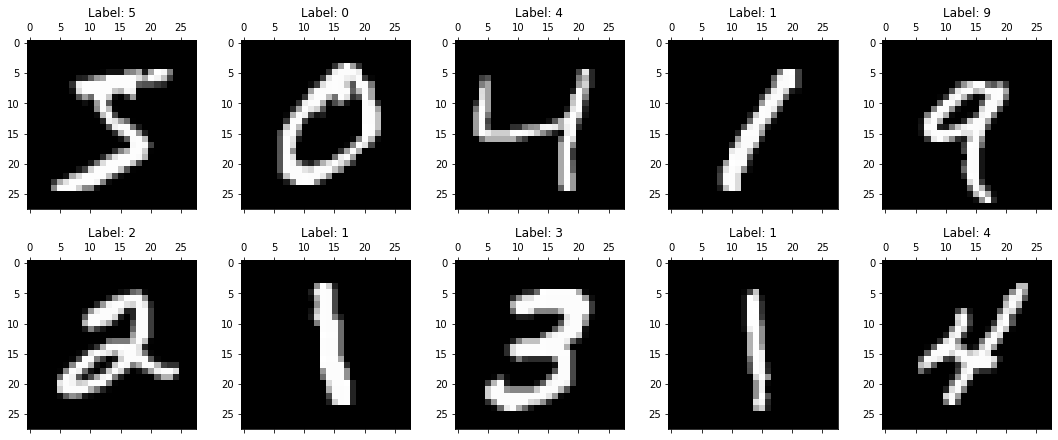

In [3]:

fig, axes = plt.subplots(2, 5, figsize=(15,6))
fig.tight_layout(h_pad=3)

for i in range(10):
  plt.gray()
  ax = plt.subplot(2, 5, i+1)
  ax.set_title("Label: "+str(y_train[i]))
  plt.matshow(X_train_raw[i],fignum=False)

plt.show()


Graficamos los 100 primeros en un tamaño pequeño:

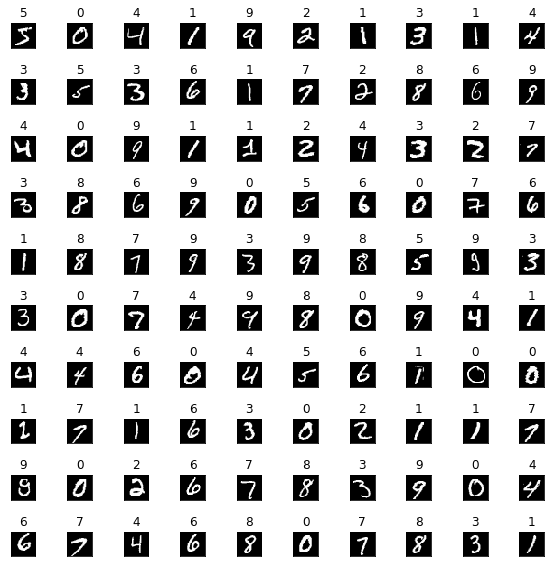

In [4]:

fig, axes = plt.subplots(10, 10, figsize=(8,8))
fig.tight_layout()

for i in range(100):
  plt.gray()
  ax = plt.subplot(10, 10, i+1)
  ax.set_title(y_train[i])
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.matshow(X_train_raw[i],fignum=False)

plt.show()


Ahora configuramos el set de entrenamiento tal y como lo requieren los modelos. Estos no manejan matrices sino arreglos, por lo que lo reformateamos para que cada dígito esté ahora representado por un arreglo de 28 x 28 = 784 elementos. Esto se logra con la función np.reshape()

In [5]:
X_train = np.reshape(X_train_raw, (60000, 784))
X_test = np.reshape(X_test_raw, (10000, 784))
print('X_train: shape():', X_train.shape,"Class:",X_train_raw.__class__)
print('X_test:  shape():', X_test.shape,"Class:",X_train_raw.__class__)


X_train: shape(): (60000, 784) Class: <class 'numpy.ndarray'>
X_test:  shape(): (10000, 784) Class: <class 'numpy.ndarray'>


Visualizamos de nuevo, esta vez usando los nuevos arreglos reconfigurados. Esto con el fin de asegurarnos que nuestros datos han sido convertidos correctamente y los dígitos aún se pueden recuperar y visualizar usando las nuevas estructuras de datos:

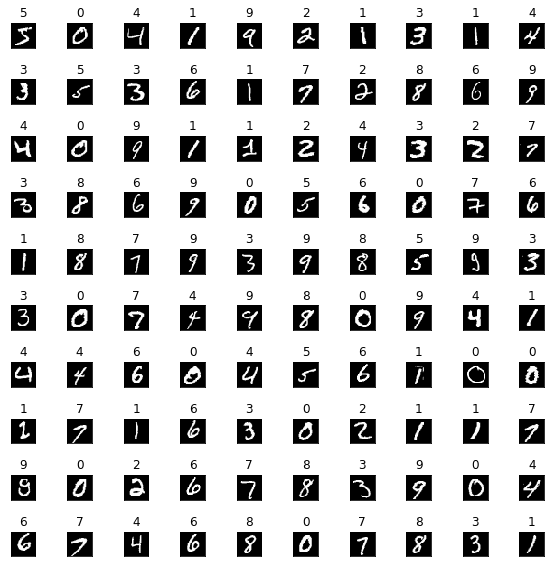

In [6]:
fig, axes = plt.subplots(10, 10, figsize=(8,8))
fig.tight_layout()

for i in range(100):
  plt.gray()
  ax = plt.subplot(10, 10, i+1)
  # Muestra el "label"
  ax.set_title(y_train[i])
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  # Inicializa un arrreglo que contendrá la imagen a desplegar
  imagen = np.zeros((28, 28))
  # Rellenamos la matriz con los pixels correspondientes
  for r in range(28):
    for c in range(28):
      imagen[r,c] = X_train[i, r*28+c]
  #Desplegamos el dígito
  plt.matshow(imagen,fignum=False)

plt.show()

Entrenamos un modelo "Dummy" que nos servirá para establecer el punto de partida y comparar con el modelo final.

Observa como las medidas están cercanas a 0.1 (10%) lo cual es de esperarse para este modelo, ya que trata de predecir cada dígito de acuerdo al porcentaje de ocurrencia. Para esto se incluye el parámetro `strategy='stratified'`. Más estrategias pueden ser consultadas siguiendo este enlace: https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

El parámetro `average='micro'` se incluye para que las métricas se calculen con base en todo el conjunto de datos y no por cada clase (dígito). Otras opciones se pueden consultar en este enlace: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

In [7]:

modeloDummy = DummyClassifier(strategy='stratified')

# entrenamos con el conjunto de entrenamiento
modeloDummy.fit(X_train, y_train)       

# Obtenemos las predicciones para los dos conjuntos
predictions_train = modeloDummy.predict(X_train)
predictions_test = modeloDummy.predict(X_test)

print('='*31)
print('DUMMY REGRESSOR:')
print('='*31)
print('ENTRENAMIENTO:')
print('Accuracy : ', accuracy_score(y_train, predictions_train))
print('Precision: ', precision_score(y_train, predictions_train, average='micro'))
print('Recall:    ', recall_score(y_train, predictions_train, average='micro'))
print()
print('PRUEBA:')
print('Accuracy : ', accuracy_score(y_test, predictions_test))
print('Precision: ', precision_score(y_test, predictions_test, average='micro'))
print('Recall:    ', recall_score(y_test, predictions_test, average='micro'))

DUMMY REGRESSOR:
ENTRENAMIENTO:
Accuracy :  0.1015
Precision:  0.1015
Recall:     0.1015

PRUEBA:
Accuracy :  0.1043
Precision:  0.1043
Recall:     0.1043


Ahora entrenamos un modelo neuronal conformada por múltiples capas de perceptrones (MLPClassifier(): Multi Layer Perceptron). Más información acerca de este modelo se puede encontrar siguiendo este enlace: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

En este caso se usaron dos capas internas con suficientes perceptrones para lograr un buen resultado. No se ha tratado de hacer ninguna optimización: los números de 500 y 100 perceptrones han sido obtenidos por prueba y error sobredimensionando las necesidades. Un ejercicio interesante sería optimizar el número de capas internar y la cantidad de perceptrones para ciertas métricas, realizando una búsqueda automática.

Por el momento, lo dejaremos sobredimensionado para no complicar este cuaderno de notas.

In [ ]:
model = MLPClassifier(max_iter=5000, hidden_layer_sizes=(500,100))

cv = RepeatedKFold(n_splits=2, n_repeats=1, random_state=10) # k-folds cross-validation

# Metrics to evaluate model
metrics = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, average='micro'),
    "recall": make_scorer(recall_score, average='micro'),
}

scores = cross_validate(model, X_train, y_train, scoring=metrics, cv=cv, return_train_score=True, n_jobs=-1)
print('ENTRENAMIENTO:')
print('mean accuracy: %.3f (%.4f)\nmean precision: %.3f (%.4f)\nmean recall: %.3f (%.4f)\n' % (
                                                                      np.mean(scores['train_accuracy']),
                                                                      np.std(scores['train_accuracy']),
                                                                      np.mean(scores['train_precision']),
                                                                      np.std(scores['train_precision']), 
                                                                      np.mean(scores['train_recall']),
                                                                      np.std(scores['train_recall']),
                                                                      ))
    
print('VALIDACION (interna al método de validación cruzada):')
print('mean accuracy: %.3f (%.4f)\nmean precision: %.3f (%.4f)\nmean recall: %.3f (%.4f)\n' % (
                                                                      np.mean(scores['test_accuracy']) ,
                                                                      np.std(scores['test_accuracy']),
                                                                      np.mean(scores['test_precision']),
                                                                      np.std(scores['test_precision']), 
                                                                      np.mean(scores['test_recall']),
                                                                      np.std(scores['test_recall']),
                                                                      ))

Podemos observar los resultados del modelo, de casi el 97%. A continuación visualizaremos algunos de los dígitos correcta- e incorrectamente clasificados, donde se observará la mala escritura, en general, de los que fueron incorrectamente clasificados. Hasta un humano los pensaría varias veces antes de identificar con seguridad algunos de esos dígitos, tal vez comparando con otros dígitos escritos por la misma persona.

In [9]:
pd.DataFrame(scores).style

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall
0,516.121737,1.853928,0.967367,0.995900,0.967367,0.995900,0.967367,0.995900
1,538.588867,0.953593,0.968633,0.993733,0.968633,0.993733,0.968633,0.993733


In [10]:
# Results over test set
print('PRUEBA:')

# Fit best model and test it
model.fit(X_train, y_train) # fit model

predictions = model.predict(X_test) # Compute predictions over test set

print('accuracy_score: %.3f\nprecision_score: %.3f\nrecall_score: %.3f\n' % (
    accuracy_score(y_test, predictions),
    precision_score(y_test, predictions, average='micro'),
    recall_score(y_test, predictions, average='micro')
))

cm = confusion_matrix(y_test, predictions, labels=range(10))
print(cm)

PRUEBA:
accuracy_score: 0.979
precision_score: 0.979
recall_score: 0.979

[[ 971    1    1    2    0    1    2    1    1    0]
 [   0 1126    1    1    0    1    2    1    3    0]
 [   1    2 1017    2    1    1    1    4    3    0]
 [   0    0    9  981    0    1    0    4   10    5]
 [   1    0    2    0  954    1    5    0    1   18]
 [   3    0    0    6    1  856   11    1   10    4]
 [   4    2    3    0    1    1  945    0    2    0]
 [   2    3    7    1    1    0    0 1006    3    5]
 [   2    0    5    3    1    3    3    3  947    7]
 [   3    3    2    1    1    2    1    3    7  986]]


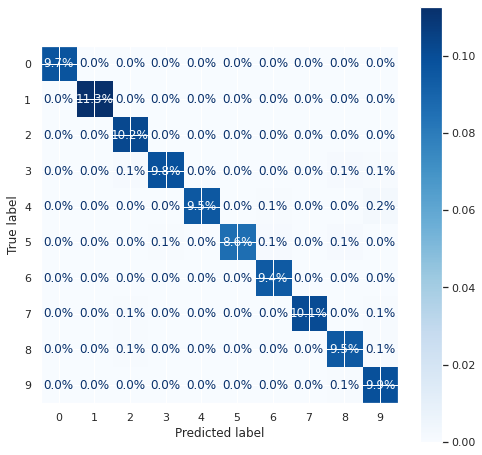

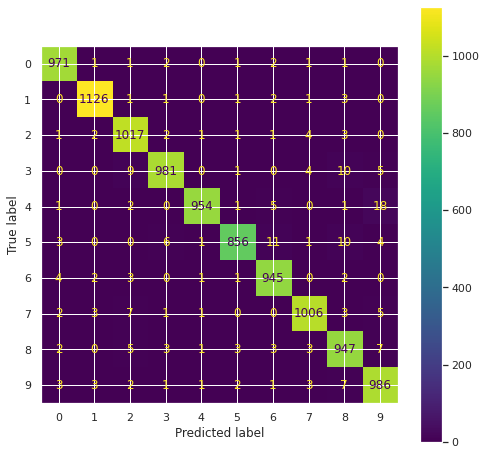

In [11]:

sns.set(rc={"figure.figsize": (8, 8)})
disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap='Blues',  normalize='all', values_format= '.1%')
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm)
disp1.plot()
plt.show()

In [12]:
print(accuracy_score(y_test, predictions))
print(precision_score(y_test, predictions, average=None))
print(recall_score(y_test, predictions, average=None))

0.9789
[0.98378926 0.99032542 0.9713467  0.98395186 0.99375    0.98731257
 0.9742268  0.98338221 0.95947315 0.96195122]
[0.99081633 0.99207048 0.98546512 0.97128713 0.97148676 0.95964126
 0.98643006 0.97859922 0.97227926 0.97720515]


Con el modelo entrenado, hagamos unas predicciones puntuales, visualizando entrada y salida:

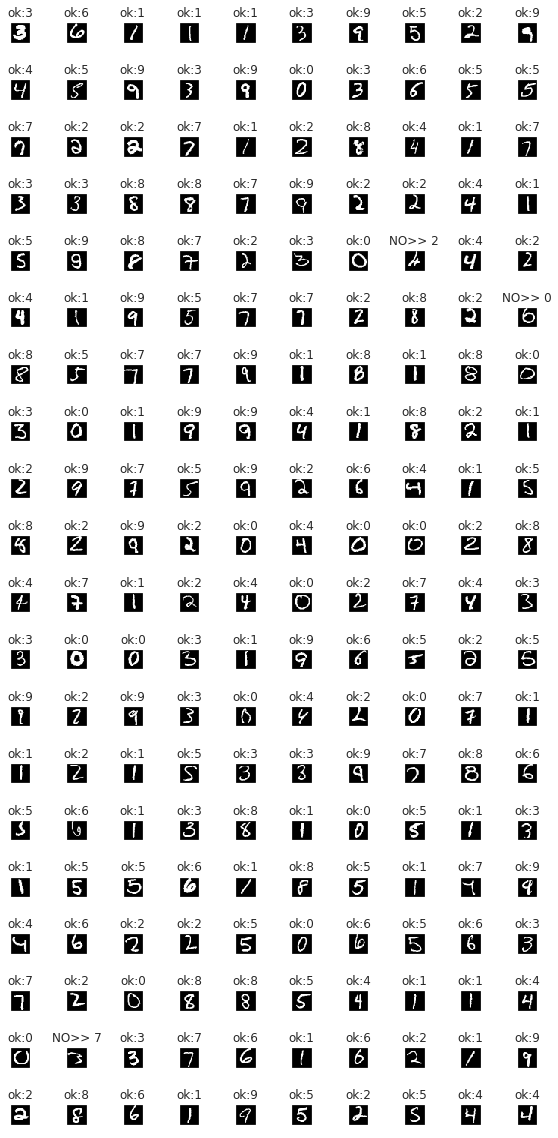

In [13]:
predictions = model.predict(X_test)

fig, axes = plt.subplots(20, 10, figsize=(8, 16))
fig.tight_layout()

for i in range(200):
  offset = 200
  plt.gray()
  ax = plt.subplot(20, 10, i+1)
  if predictions[offset+i] == y_test[offset+i]:
    label = 'ok:'
  else:
    label = 'NO>> '
  ax.set_title(label + str(predictions[offset+i]))
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  imagen = np.zeros((28, 28))
  for r in range(28):
    for c in range(28):
      imagen[r,c] = X_test[offset+i, r*28+c]
  plt.matshow(imagen,fignum=False)

plt.show()

Por último, mostramos los primeros 100 números que ek modelo no pudo predecir correctamente. Se puede apreciar que, en general, están mal escritos!!

Aquí hay algunos de los errores: (V=Verdadero, P=Predicción)


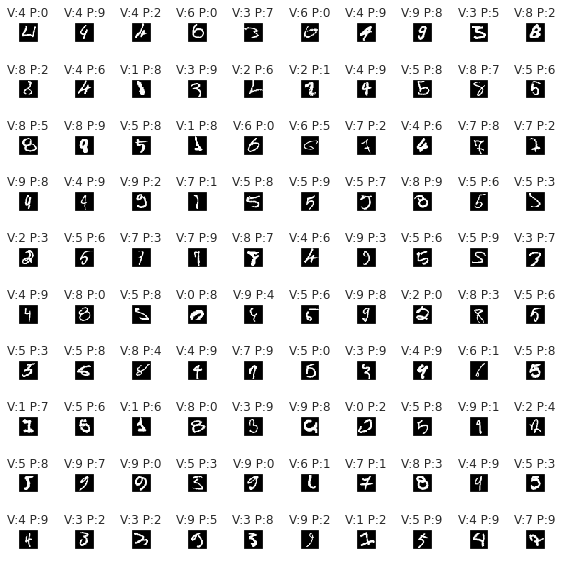

In [14]:
print("Aquí hay algunos de los errores: (V=Verdadero, P=Predicción)")
print("================================")

fig, axes = plt.subplots(10, 10, figsize=(8, 8))
fig.tight_layout()

i = 0
graficas = 0
offset = 0
while graficas < 100:

  if predictions[offset+i] != y_test[offset+i]:
    plt.gray()
    graficas = graficas + 1
    ax = plt.subplot(10, 10, graficas)
    ax.set_title('V:'+ str(y_test[offset+i]) + ' P:'+ str(predictions[offset+i]))
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    imagen = np.zeros((28, 28))
    for r in range(28):
      for c in range(28):
        imagen[r,c] = X_test[offset+i, r*28+c]
    plt.matshow(imagen,fignum=False)
  
  i = i + 1

plt.show()